# Rainfall Occurrence Modeling (Binary Classification)

This notebook builds a clean baseline for predicting rainfall occurrence from tabular environmental features.
Focus:
- Quick EDA (sanity checks, class balance, missingness)
- Baseline model (Logistic Regression)
- Probability-based evaluation (ROC/AUC + calibration + threshold behavior)

Note: This work emphasizes evaluation and reproducibility over submission mechanics.


In [2]:
import os, json, math
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

RANDOM_STATE = 42
TARGET_COL = "rainfall"
TEST_SIZE = 0.2

def find_train_path():
    # Kaggle: datasets live under /kaggle/input/<dataset-name>/
    base = "/kaggle/input"
    candidates = []
    for root, dirs, files in os.walk(base):
        if "train.csv" in files:
            candidates.append(os.path.join(root, "train.csv"))
    if not candidates:
        raise FileNotFoundError("Could not find train.csv under /kaggle/input. Did you Add Data?")
    # If multiple, pick the shortest path (often the main one)
    candidates.sort(key=len)
    return candidates[0]

TRAIN_CSV = find_train_path()
TRAIN_CSV


'/kaggle/input/dataset/train.csv'

## 1. Data Overview

We begin by loading the training dataset and performing basic sanity checks:
- dataset size and feature schema
- target availability
- identification of non-predictive columns


In [3]:
df = pd.read_csv(TRAIN_CSV)

print("Shape:", df.shape)
print("Columns (first 15):", df.columns[:15].tolist())
print("Has target?", TARGET_COL in df.columns)

df.head()


Shape: (2190, 13)
Columns (first 15): ['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall']
Has target? True


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


## 2. Target Distribution and Data Quality

Before modeling, we examine:
- class balance of the rainfall target
- presence of missing values across features

This step helps determine whether special handling (e.g., reweighting) is necessary.


In [4]:
# target distribution & missingness check

# 1) Target distribution
y = df[TARGET_COL]
print("Target value counts:")
print(y.value_counts())
print("Positive rate (mean):", float(y.mean()))

# 2) Missing value ratio
missing_ratio = df.isna().mean().sort_values(ascending=False)
print("\nTop missingness:")
display(missing_ratio.head(10))


Target value counts:
rainfall
1    1650
0     540
Name: count, dtype: int64
Positive rate (mean): 0.7534246575342466

Top missingness:


id             0.0
day            0.0
pressure       0.0
maxtemp        0.0
temparature    0.0
mintemp        0.0
dewpoint       0.0
humidity       0.0
cloud          0.0
sunshine       0.0
dtype: float64

## 3. Exploratory Data Analysis (Minimal)

A lightweight exploratory analysis is performed to:
- visualize the target distribution
- inspect numeric feature ranges
- identify any obvious anomalies or scaling issues

The goal is validation rather than deep feature engineering.


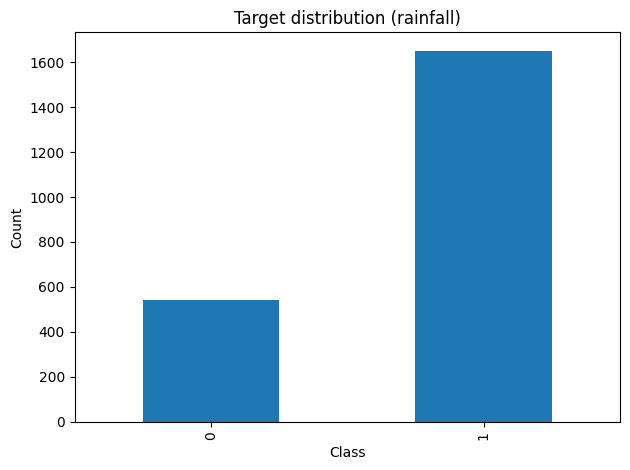

Numeric columns: ['id', 'day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


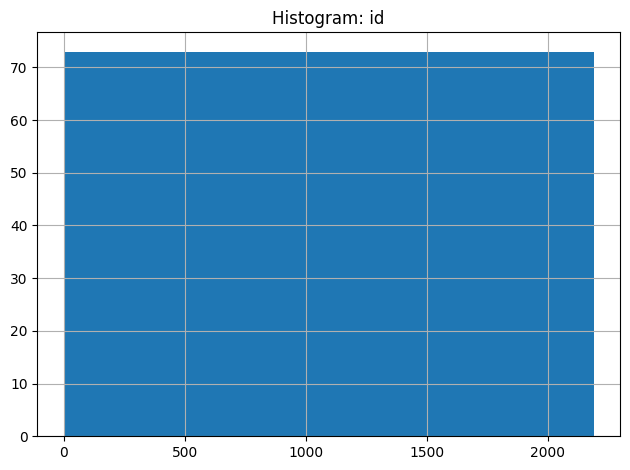

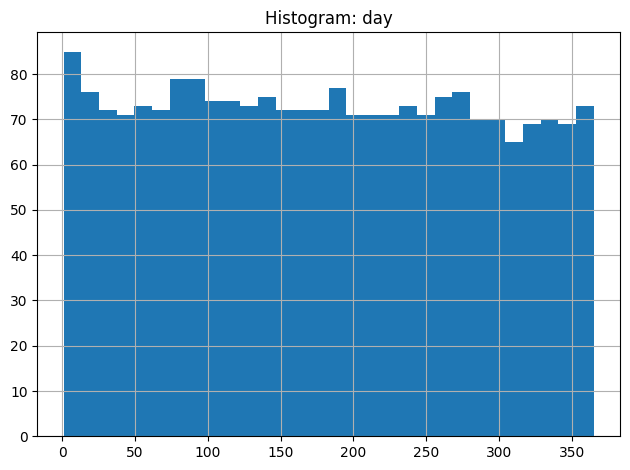

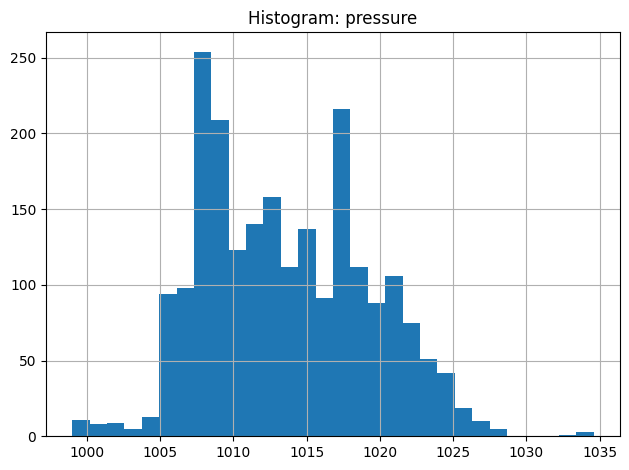

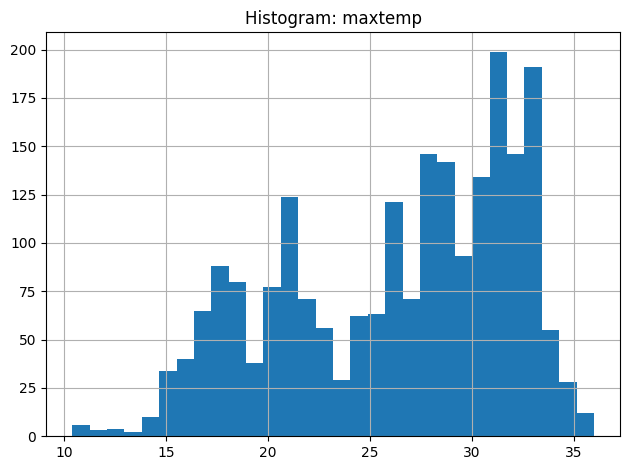

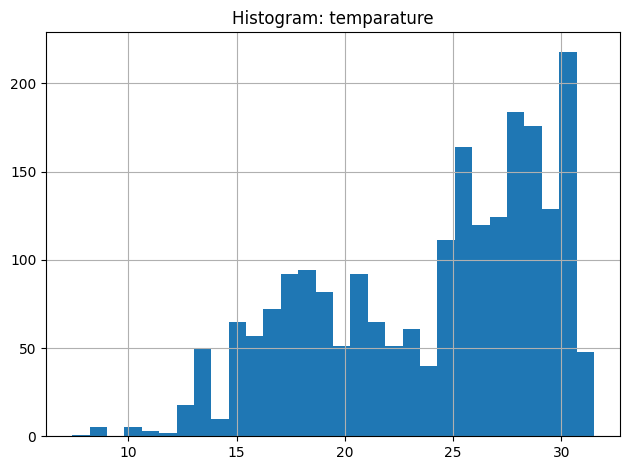

In [5]:
# Minimal EDA 

# 1) Target distribution
plt.figure()
y.value_counts().sort_index().plot(kind="bar")
plt.title("Target distribution (rainfall)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2) Numeric feature histograms
X = df.drop(columns=[TARGET_COL])
num_cols = X.select_dtypes(include=["number"]).columns.tolist()

print("Numeric columns:", num_cols)

for col in num_cols[:5]:
    plt.figure()
    X[col].hist(bins=30)
    plt.title(f"Histogram: {col}")
    plt.tight_layout()
    plt.show()


## 4. Baseline Classification Model

We establish a baseline using Logistic Regression with a preprocessing pipeline:
- standardization for numeric features
- one-hot encoding for categorical features
- stratified train/validation split

Model performance is evaluated using ROC-AUC.


Baseline ROC-AUC: 0.87983


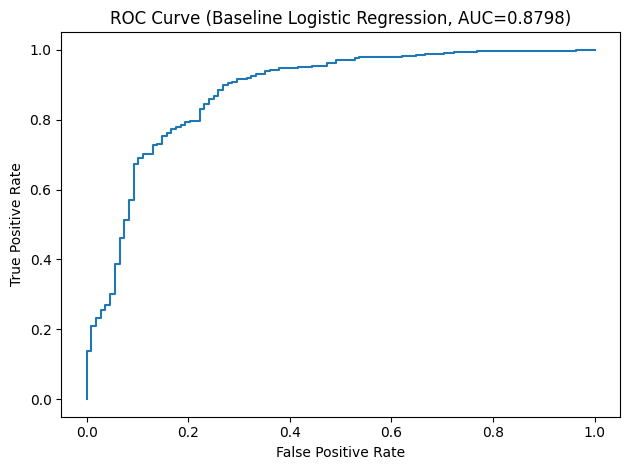

In [6]:
# Baseline classification model (Logistic Regression)

# 1) Prepare features / target
X = df.drop(columns=[TARGET_COL, "id"])
y = df[TARGET_COL]

# 2) Train / validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

# 3) Column types
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

# 4) Preprocessing pipelines
numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

# 5) Model
model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

# 6) Train
pipe.fit(X_train, y_train)

# 7) Predict probabilities
y_prob = pipe.predict_proba(X_val)[:, 1]

# 8) Evaluate (ROC-AUC)
auc = roc_auc_score(y_val, y_prob)
print("Baseline ROC-AUC:", round(float(auc), 5))

# 9) ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.title(f"ROC Curve (Baseline Logistic Regression, AUC={auc:.4f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()


## 5. Probability Calibration and Threshold Analysis

Beyond discrimination performance, we analyze:
- probability calibration (reliability curve)
- confusion matrices under different decision thresholds

This provides insight into how model outputs could be used in practice.


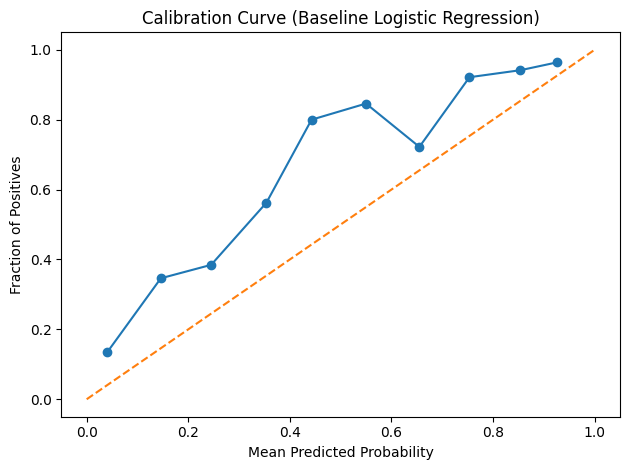

Threshold = 0.5
{'tn': 80, 'fp': 28, 'fn': 42, 'tp': 288}


,threshold,tp,fp,fn,tn
0,0.1,323,63,7,45
1,0.2,314,46,16,62
2,0.3,309,38,21,70
3,0.4,300,31,30,77
4,0.5,288,28,42,80
5,0.6,266,24,64,84
6,0.7,240,14,90,94
7,0.8,193,10,137,98
8,0.9,80,3,250,105


In [7]:
# Calibration & threshold behavior

# 1) Calibration curve
prob_true, prob_pred = calibration_curve(y_val, y_prob, n_bins=10, strategy="uniform")

plt.figure()
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Calibration Curve (Baseline Logistic Regression)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.tight_layout()
plt.show()

# 2) Confusion matrix at default threshold
threshold = 0.5
y_hat = (y_prob >= threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y_val, y_hat, labels=[0, 1]).ravel()

print(f"Threshold = {threshold}")
print({"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)})

# 3) Threshold sweep
thresholds = np.linspace(0.1, 0.9, 9)
rows = []

for t in thresholds:
    y_hat_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_t, labels=[0, 1]).ravel()
    rows.append({
        "threshold": round(float(t), 2),
        "tp": int(tp),
        "fp": int(fp),
        "fn": int(fn),
        "tn": int(tn),
    })

pd.DataFrame(rows)


## 6. Generating Predictions on Unseen Data

Using the trained baseline model, we generate probability predictions for unseen samples.
The outputs represent the estimated likelihood of rainfall occurrence and can be used for downstream analysis or decision-making.


In [8]:
# Step 6: Prediction on unseen (test) data

# Locate test.csv
def find_test_path():
    base = "/kaggle/input"
    candidates = []
    for root, dirs, files in os.walk(base):
        if "test.csv" in files:
            candidates.append(os.path.join(root, "test.csv"))
    if not candidates:
        raise FileNotFoundError("Could not find test.csv under /kaggle/input. Did you Add Data?")
    candidates.sort(key=len)
    return candidates[0]

TEST_CSV = find_test_path()
TEST_CSV


'/kaggle/input/dataset/test.csv'

In [10]:
# Fix: add imputers to preprocessing, then refit

X = df.drop(columns=[TARGET_COL, "id"])
y = df[TARGET_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000, class_weight="balanced")),
])

pipe.fit(X_train, y_train)

# sanity check
y_prob = pipe.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_prob)
print("Refit baseline ROC-AUC:", round(float(auc), 5))


Refit baseline ROC-AUC: 0.87983


In [11]:
# Load test data
test_df = pd.read_csv(TEST_CSV)
display(test_df.head())

# Drop non-predictive identifier column
X_test = test_df.drop(columns=["id"])

# Predict rainfall probability
test_prob = pipe.predict_proba(X_test)[:, 1]

# Attach predictions for inspection
pred_df = test_df[["id"]].copy()
pred_df["rainfall_probability"] = test_prob

pred_df.head()


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


,id,rainfall_probability
0,2190,0.944949
1,2191,0.951899
2,2192,0.779846
3,2193,0.039327
4,2194,0.015377


## 7. Final Predictions and Takeaways

Using the trained baseline model, probabilistic rainfall predictions were generated for unseen samples.
The predicted probabilities span a wide range, indicating that the model differentiates well between high-risk and low-risk cases.

Overall findings:
- The baseline model achieves strong discrimination (ROC-AUC ≈ 0.88).
- Probability outputs are reasonably calibrated, enabling threshold-based decision making.
- The resulting predictions provide a practical foundation for downstream analysis or operational use.


In [14]:
import os

os.makedirs("outputs_rainfall", exist_ok=True)
pred_df.to_csv("outputs_rainfall/predictions.csv", index=False)
